## Lab - Anamoly Detection using Outlier Analysis

Outlier Analysis is used by many organizations for various purposes. We are going to identify outliers using two different methods in this problem: 

1) Using Interquantile range <br>

2) Using PyOD and K-means

We will be using the Glass dataset for this lab. The data deals with identifying different types of glass for criminological investigations. This is a UCI dataset, which can be found [here](https://archive.ics.uci.edu/ml/datasets/Glass+Identification). The columns of the dataset are: 

Attribute Information:
   1. Id number: 1 to 214 <br>
   2. RI: refractive index <br>
   3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as 
                  are attributes 4-10)
   4. Mg: Magnesium <br>
   5. Al: Aluminum <br>
   6. Si: Silicon <br>
   7. K: Potassium <br>
   8. Ca: Calcium <br>
   9. Ba: Barium <br>
  10. Fe: Iron <br>
  11. Type of glass: (class attribute) <br>
  
      - 1 building_windows_float_processed <br>
      - 2 building_windows_non_float_processed <br>
      - 3 vehicle_windows_float_processed <br>
      - 4 vehicle_windows_non_float_processed (none in this database) <br>
      - 5 containers <br>
      - 6 tableware <br>
      - 7 headlamps <br>

Source: [UCI glass dataset](https://archive.ics.uci.edu/ml/datasets/Glass+Identification)

This dataset is intented for classification; we have to use the concentration of eleements to identify the typ of glass found on the crime scene. The labels are given in the last column. 

For our purposes, we will use certain columns in the data to identify outliers. We ask

1) What are the outliers in the 5 th column i.e the Aluminum weight percent. This is just an example you can do this for any column  <br>
2) Can we 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from pyod.models.iforest import IForest
from scipy import stats
from scipy.interpolate import Rbf

glass_df = pd.read_csv("../../../data/glass.csv")
glass_df.head()

,Id_Number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


# Part I : Identify Outliers in the Al column 

First part involves plotting a box plot from the data frame, then calcuating the outliers. 


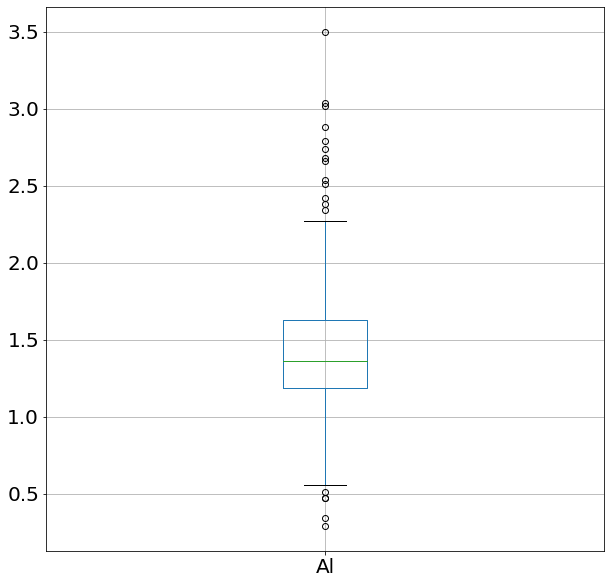

In [2]:
# Plot the outliers with figsie=(10,10) and a fontsize of 20 
glass_df.boxplot("Al", figsize=(10,10), fontsize=20)

<img src="../../../images/outlier_analysis-boxplot.png">

Visually inspecting the boxplot shows that there are outlier points. In the next few cells we will get the values of these outliers. 

In [3]:

# The variable single_col contains the series for Al column 
single_col = glass_df["Al"]

# Get the 1st and 3rd quantile values for the varaible single_col
quantile_1 = single_col.quantile(0.25)
quantile_3 = single_col.quantile(0.75)

# Calcaute the IQR 
IQR = quantile_3 - quantile_1

# Filter the outliers out of single_col. You can use df.between to get values between the 
# IQR values
outliers = single_col[~single_col.between(quantile_1- 1.5*IQR, quantile_3 +1.5*IQR)]
outliers_value = list(outliers.values)
print(outliers_value)

[0.29, 0.47, 0.47, 0.51, 3.5, 3.04, 3.02, 0.34, 2.38, 2.79, 2.68, 2.54, 2.34, 2.66, 2.51, 2.42, 2.74, 2.88]


[0.29, 0.47, 0.47, 0.51, 3.5, 3.04, 3.02, 0.34, 2.38, 2.79, 2.68, 2.54, 2.34, 2.66, 2.51, 2.42, 2.74, 2.88]

## Part II: Use pyOD and K-means to identify K-means 

In this part we are going to use two columns from the glass dataset and identify a proportion of outliers. 

In [4]:
# First step is to filter out two columns Al and Ca
two_cols = glass_df[['Al', 'Ca']]

In [5]:
# We need convert two_cols to a 2d- numpy array
X= two_cols.values

# We set the outliers_fraction to 0.1 
outliers_fraction = 0.1

# We want to visualize the inlier and outlier region hence we declare meshgrid
xx , yy = np.meshgrid(np.linspace(0, 5, 50), np.linspace(0, 17, 50))


In [6]:
# Initalize an IForest method with a contaimation equal to the outliers_fraction 
# random_state of 0.
clf =IForest(contamination=outliers_fraction, random_state=0)
clf.fit(X)

# To make predict, first run classifer.predict on the two_cols data
y_pred = clf.predict(X)

# We need to get the number of inliers and outliers. 
# The number of outliers are all those points labeled 1 
# in y_pred
n_outliers = np.count_nonzero(y_pred == 1)

# Once you have the number of outliers, get the number of
# inlier points
n_inliers = len(y_pred) - n_outliers

print("Total number of outlier and inlier points are: {} and {}".format(n_outliers, n_inliers))

Total number of outlier and inlier points are: 22 and 192


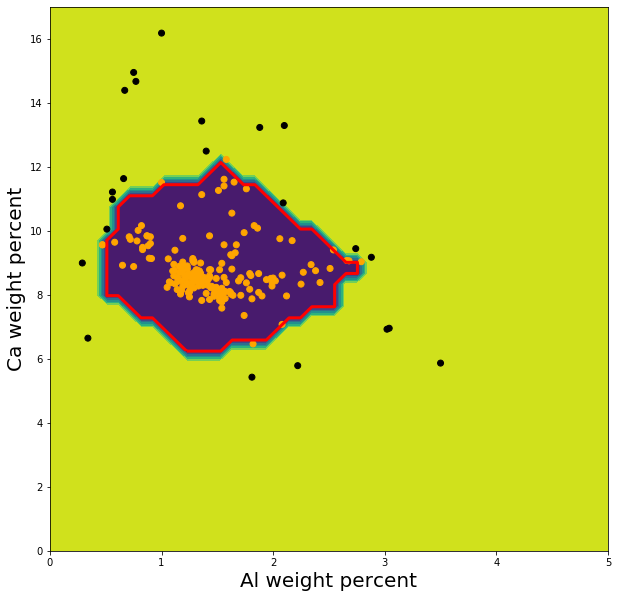

In [7]:
# In this step we the boundary between the outlier and inlier region
scores_pred = clf.decision_function(X) * -1
boundary_threshold = stats.scoreatpercentile(scores_pred, 100 *outliers_fraction) 

# In order to plot a contour plot we need to first make predict on a 2d grid of points
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Make Z the same shape as xx
Z_reshaped = Z.reshape(xx.shape)

# We need to label the points as inside and outside the boundary
color_pts = np.zeros(scores_pred.shape)
color_pts[scores_pred <= boundary_threshold] = 1
color_pts[scores_pred > boundary_threshold] = 0
color_label = []
for x in color_pts: 
    if x == 0:
        color_label.append("orange")
    else: 
        color_label.append("black")

# We need a filled contour plot which is given by contourf, plot it 
# The arguments of the plot will be the meshgrid values of x and y with z 
# begin the label
plt.figure(figsize=(10,10))
plt.contourf(xx, yy, Z_reshaped)

# We need to plot a regular contour plot with x, y and z similar to above
# The levels tells you at what value of contour boundary should we draw the red 
# line that seperates the outlier points with the inliers
plt.contour(xx, yy, Z_reshaped, levels=[boundary_threshold],linewidths=3, colors='red')
plt.scatter(two_cols['Al'], two_cols['Ca'], c=color_label)
plt.xlim([0,5])
plt.ylim([0,17])
plt.xlabel("Al weight percent", fontsize=20)
plt.ylabel("Ca weight percent", fontsize=20)
plt.show()

<img src="../../../images/outlier_analysis-2d.png">

The points within the red boundary can be considered inside points and the points outside can be considered as outliers. 